In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import glob
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import callbacks

# random seed
SEED = 99
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(os.listdir("../input"))

['asl-rgb-depth-fingerspelling-spelling-it-out']


# **Loading the Data**

In [82]:
def get_labels_images(path):
    labels = []
    images = []
    directories = []
    for directory in os.listdir(dataset_dir):
        for Label in os.listdir(dataset_dir+'/'+directory):
            for Image in os.listdir(dataset_dir+'/'+directory+'/'+Label):
                directories.append(directory)
                labels.append(Label)
                images.append(directory +'/'+Label+'/'+Image)
    #print(len(images),len(labels),len(directories))
    return pd.DataFrame({'directories':directories,'labels':labels,'images':images})

dataset_dir = os.path.abspath('../input/asl-rgb-depth-fingerspelling-spelling-it-out/dataset5/')
data = get_labels_images(dataset_dir)

In [83]:
def random_sample_plot(X):
    plt.figure(figsize=(15, 18))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        sample = random.choice(X['images'])
        image = load_img(dataset_dir+'/'+sample,target_size=(64,64))
        plt.imshow(image)
        plt.title("label:{},\nimage:{}".format(X[X['images']==sample]['labels'].values,sample))
    plt.show()

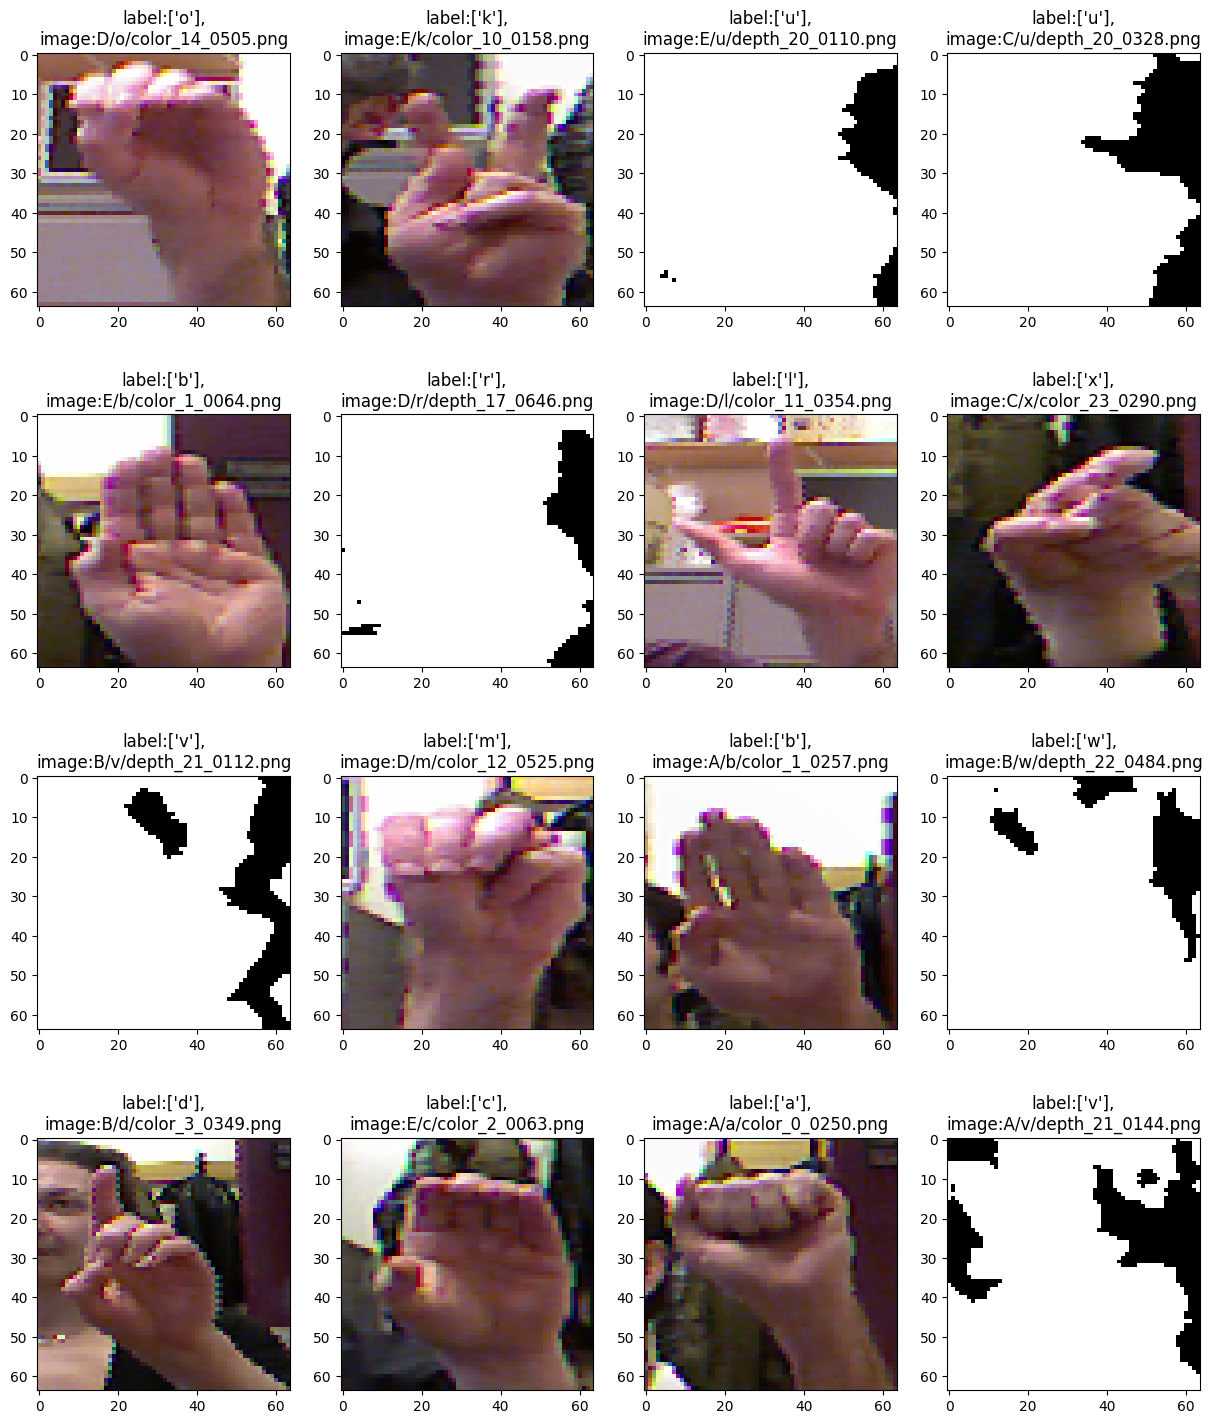

In [84]:
random_sample_plot(data)

In [85]:
color_data = data[data['images'].map(
    lambda x: True if x.find('color')!=-1 else False)].reset_index(drop=True)
deep_data = data[data['images'].map(
    lambda x: True if x.find('color')==-1 else False)].reset_index(drop=True)

In [86]:
data.shape[0]==(color_data.shape[0]+deep_data.shape[0])

True

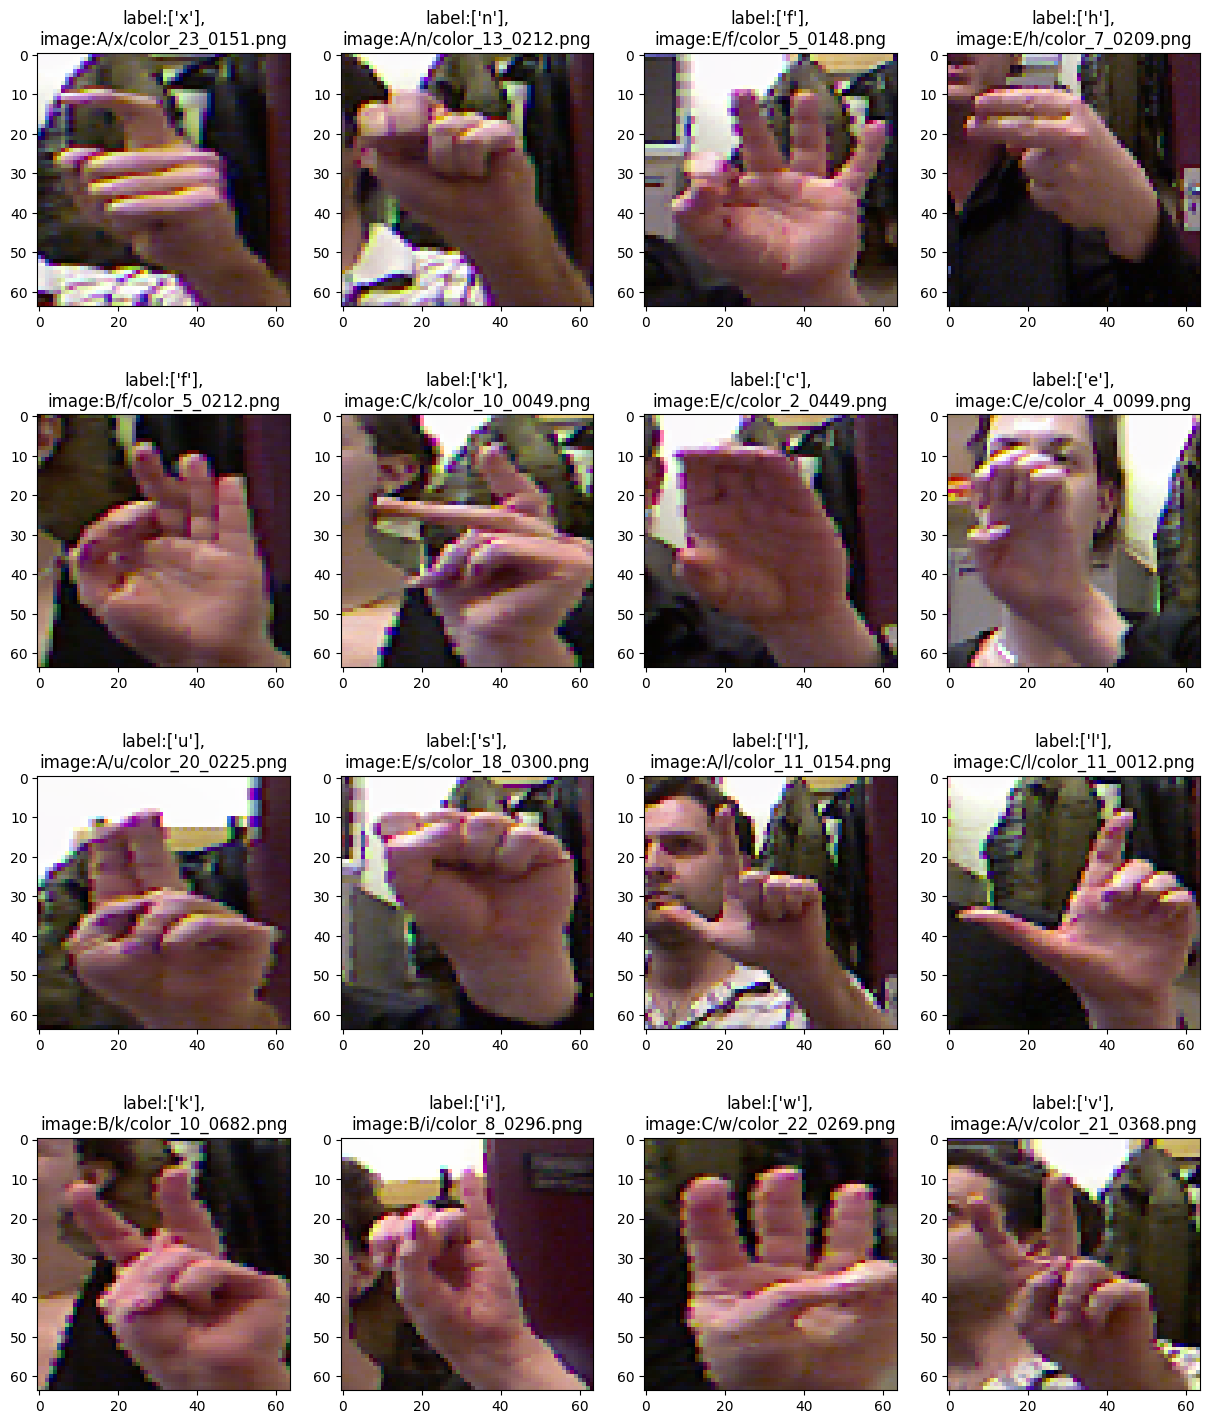

In [87]:
random_sample_plot(color_data)

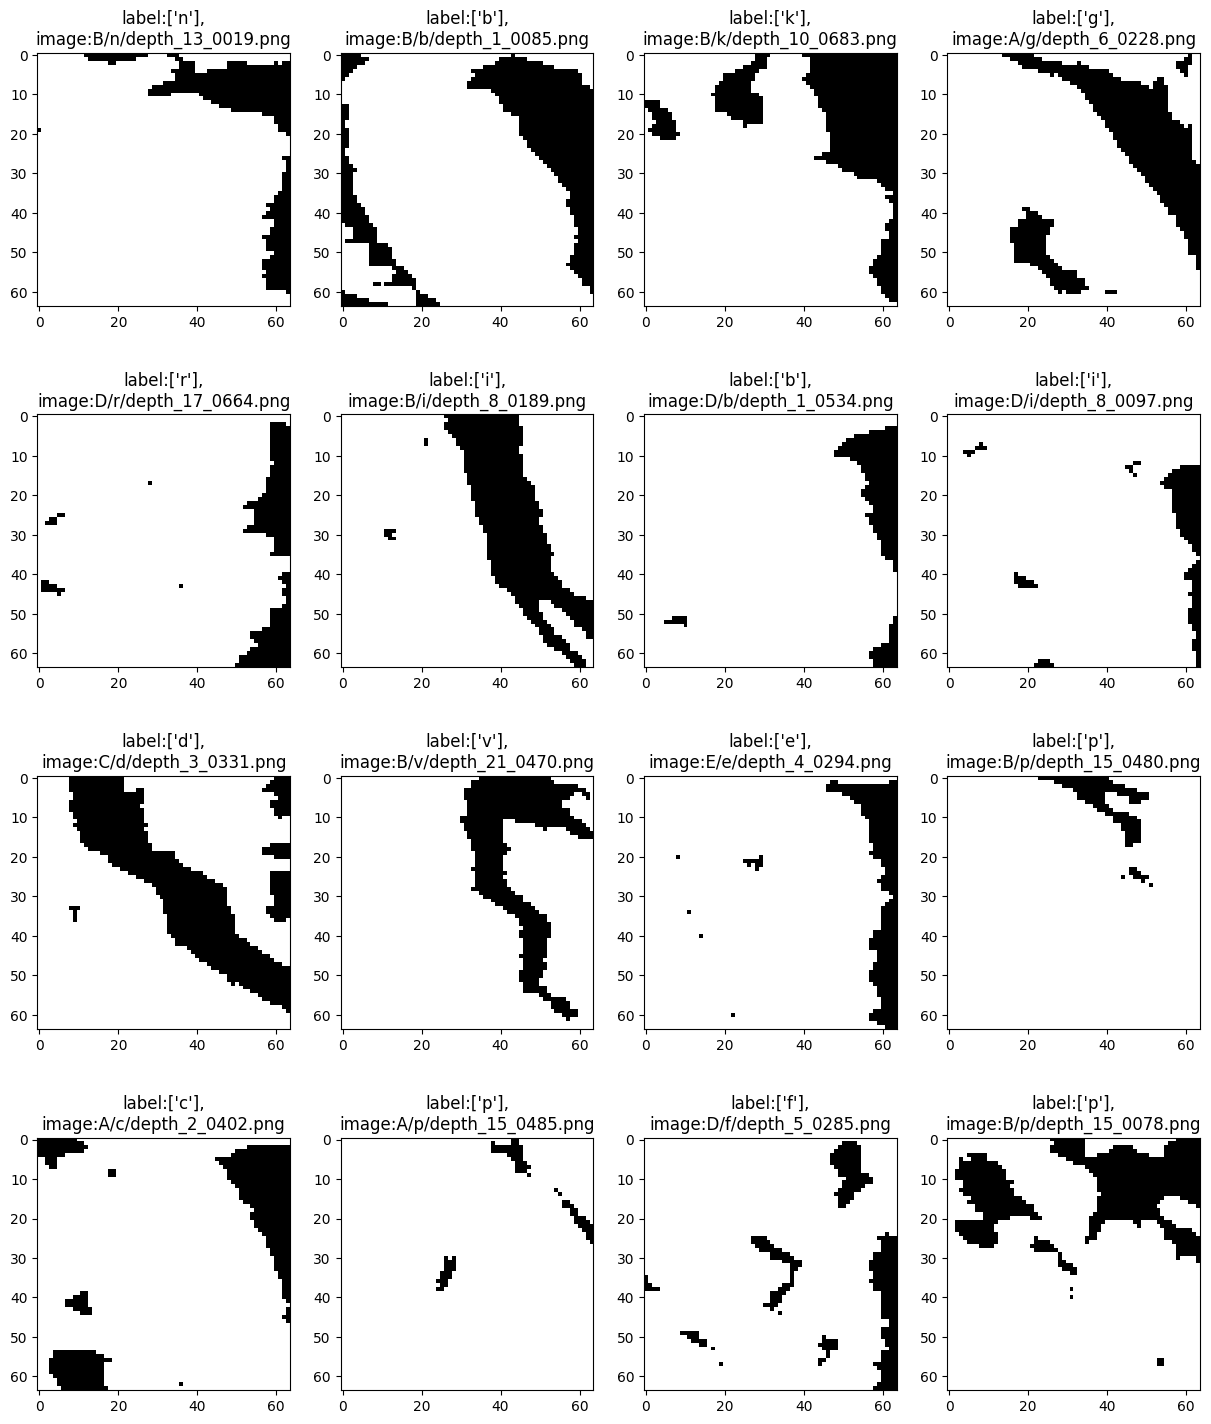

In [88]:
random_sample_plot(deep_data)

# **Preprocess Images**

In [89]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS= 3
BATCH_SIZE = 128
SEED = 99
EPOCHS = 20

Samples before preprocessing:


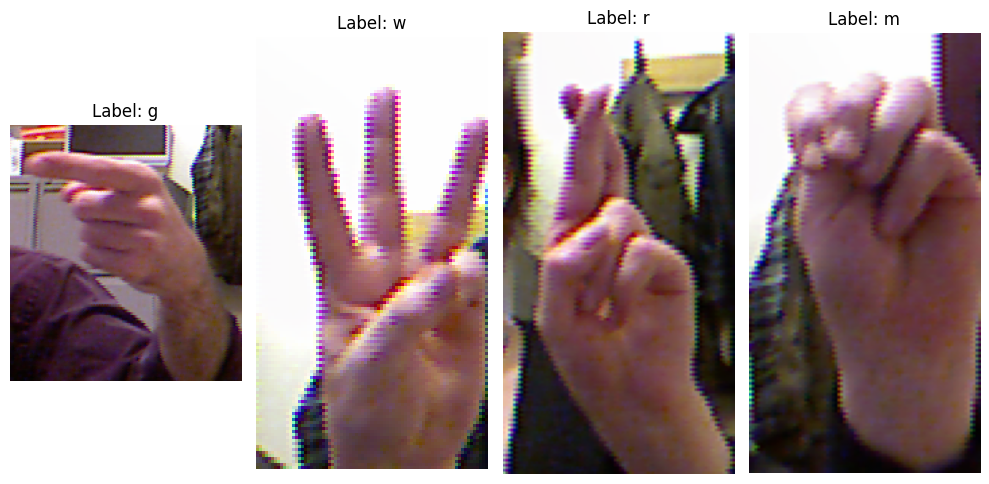

Label mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
Samples after preprocessing:


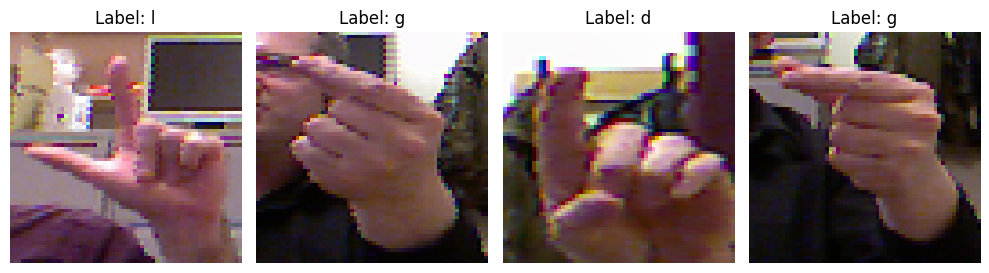

In [90]:
# Preprocessing function
def preprocess_images(data, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    X = []
    y = []
    for _, row in data.iterrows():
        img_path = os.path.join(dataset_dir, row['images'])
        # Load and preprocess image
        image = load_img(img_path, target_size=target_size)  
        image = img_to_array(image) / 255.0  
        X.append(image)
        y.append(row['labels'])
    return np.array(X), np.array(y)

# Filter color images from the dataset
color_data = data[data['images'].str.contains('color')].reset_index(drop=True)

# Display random samples of color images before preprocessing
def display_before_preprocessing(data, num_samples=4):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        sample = random.choice(data.index)
        img_path = os.path.join(dataset_dir, data.loc[sample, 'images'])
        image = load_img(img_path)  # Load without resizing
        plt.imshow(image)
        plt.title(f"Label: {data.loc[sample, 'labels']}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display random samples after preprocessing
def display_after_preprocessing(X, y, label_encoder, num_samples=4):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i])
        decoded_label = label_encoder.inverse_transform([y[i]])[0]  # Decode label
        plt.title(f"Label: {decoded_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show samples before preprocessing
print("Samples before preprocessing:")
display_before_preprocessing(color_data)

# Preprocess color images
X_color, y_color = preprocess_images(color_data, target_size=IMAGE_SIZE)


label_encoder = LabelEncoder()
y_color_encoded = label_encoder.fit_transform(y_color)

# Check label mapping
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_color, y_color_encoded, test_size=0.2, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)

# Show samples after preprocessing
print("Samples after preprocessing:")
display_after_preprocessing(X_train, y_train, label_encoder)

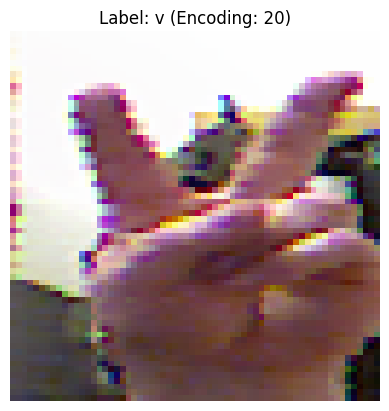

In [91]:
def display_image_by_label(X, y, label_encoder, label_encoding):
    """
    Display a single image corresponding to a specific label encoding.
    
    Parameters:
    - X: The preprocessed images array.
    - y: The encoded labels array.
    - label_encoder: The LabelEncoder used to encode the labels.
    - label_encoding: The encoded label value (integer).
    """
    # Find the indices of images with the specified label encoding
    indices = np.where(y == label_encoding)[0]
    if len(indices) == 0:
        print(f"No images found for label encoding: {label_encoding}")
        return
    
    # Pick a random index from the matching images
    random_index = random.choice(indices)
    
    # Decode the label back to its original form
    decoded_label = label_encoder.inverse_transform([label_encoding])[0]
    
    # Display the image
    plt.imshow(X[random_index])
    plt.title(f"Label: {decoded_label} (Encoding: {label_encoding})")
    plt.axis("off")
    plt.show()

specific_label_encoding = 20  
display_image_by_label(X_train, y_train, label_encoder, specific_label_encoding)


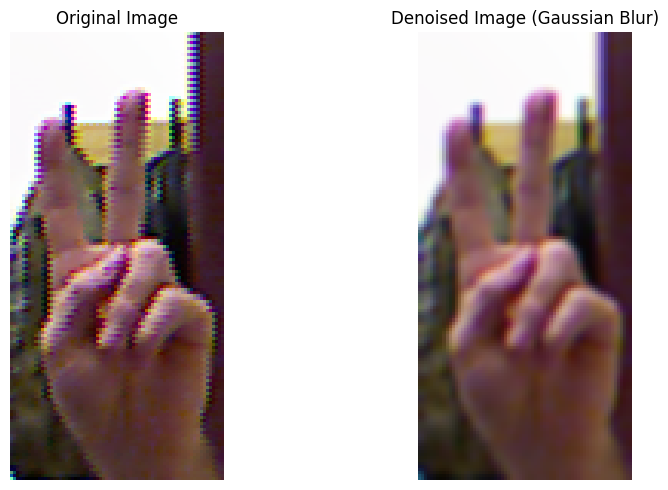

In [96]:
def remove_noise_from_image(image, kernel_size=(5, 5)):
    # Convert image to NumPy array if it's a PIL image
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Scale image back to [0, 255] range if normalized
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Apply Gaussian Blur
    denoised_image = cv2.GaussianBlur(image, kernel_size, 0)

    return denoised_image

def visualize_original_and_denoised(image_path, kernel_size=(5, 5)):
    
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Load the image
    original_image = load_img(image_path)  # Load without resizing
    original_array = img_to_array(original_image) / 255.0  # Normalize to [0, 1]

    # Apply noise removal
    denoised_image = remove_noise_from_image(original_array, kernel_size)

    # Plot original and denoised images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_array)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap="gray")
    plt.title("Denoised Image (Gaussian Blur)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example Usage
image_path = "/kaggle/input/asl-rgb-depth-fingerspelling-spelling-it-out/dataset5/A/v/color_21_0002.png"  # Replace with the path to your image
visualize_original_and_denoised(image_path, kernel_size=(5, 5))


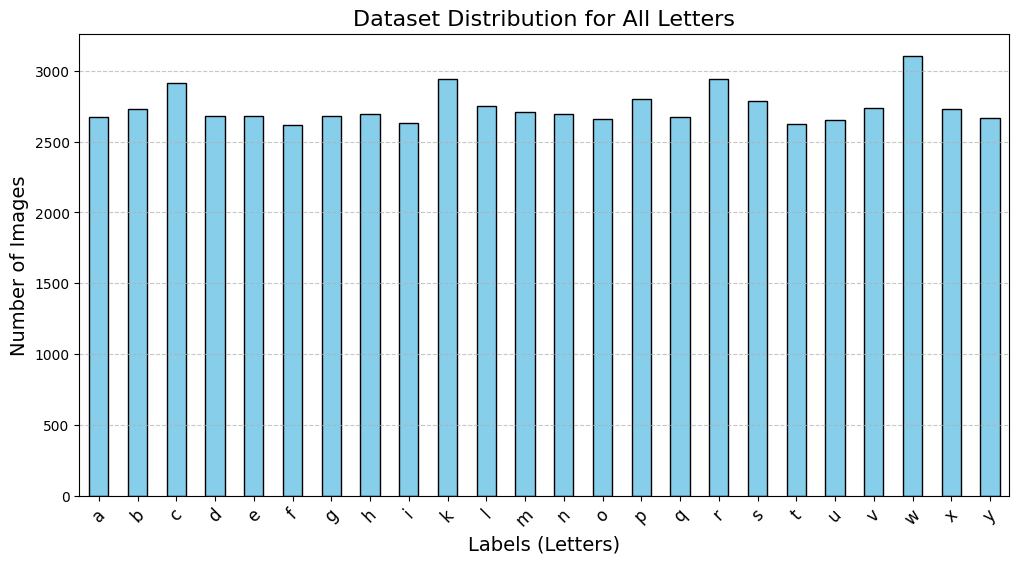

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_label_distribution(data, title="Label Distribution"):
   
    # Count the occurrences of each label
    label_counts = data['labels'].value_counts()

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    label_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Labels (Letters)", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function to plot label distribution
plot_label_distribution(color_data, title="Dataset Distribution for All Letters")

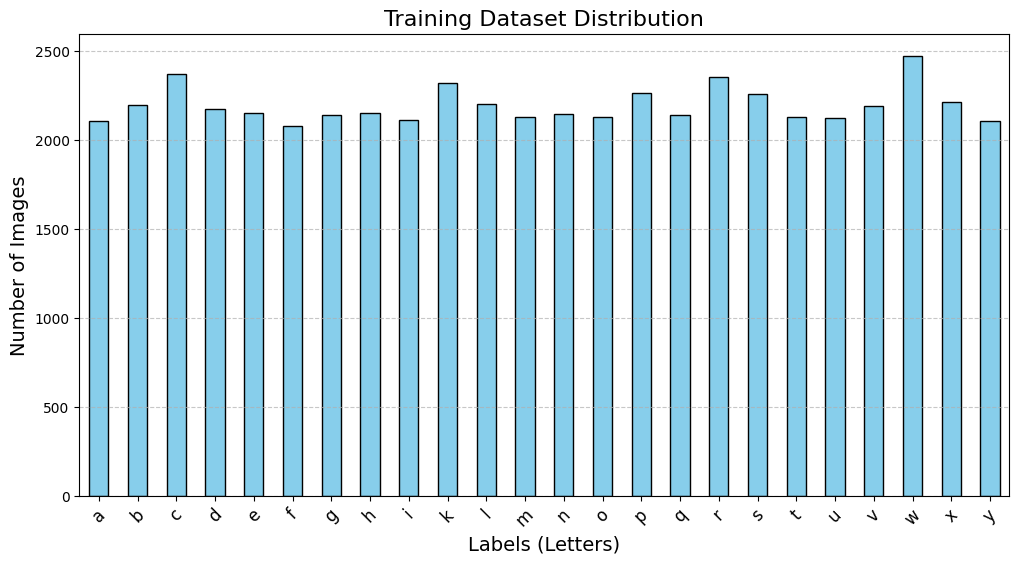

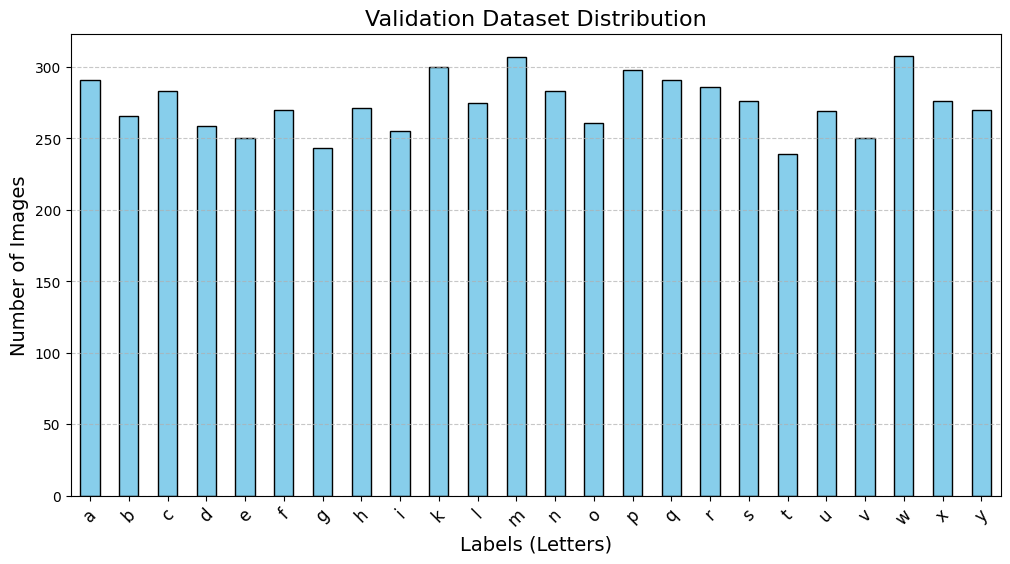

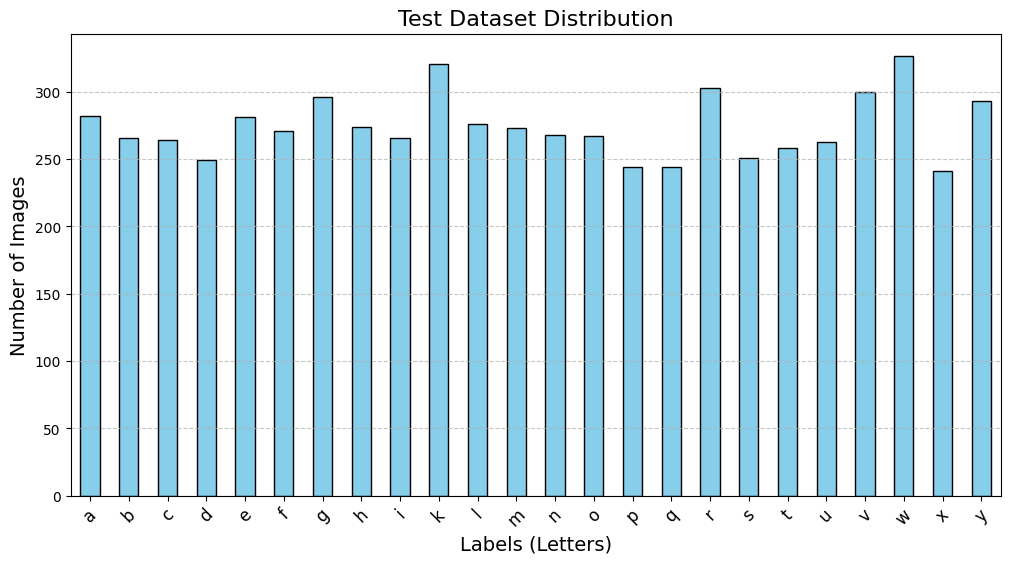

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_label_distribution(dataset, labels, title="Label Distribution"):
    # Convert encoded labels back to original labels
    label_names = [labels[label] for label in dataset]
    
    # Count the occurrences of each label
    label_counts = pd.Series(label_names).value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Labels (Letters)", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Get original label names from the LabelEncoder
original_labels = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Visualize training dataset
plot_label_distribution(y_train, original_labels, title="Training Dataset Distribution")

# Visualize validation dataset
plot_label_distribution(y_val, original_labels, title="Validation Dataset Distribution")

# Visualize test dataset
plot_label_distribution(y_test, original_labels, title="Test Dataset Distribution")


# **CNN**

In [63]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Define a more complex CNN model
def build_large_cnn(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(128, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Block 3
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Fully connected layers
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Model parameters
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
num_classes = len(label_encoder.classes_)

# Build and compile the larger model
model = build_large_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 60, 60, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 26, 26, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 9, 9, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,510,296 (51.54 MB)

 Trainable params: 13,506,712 (51.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

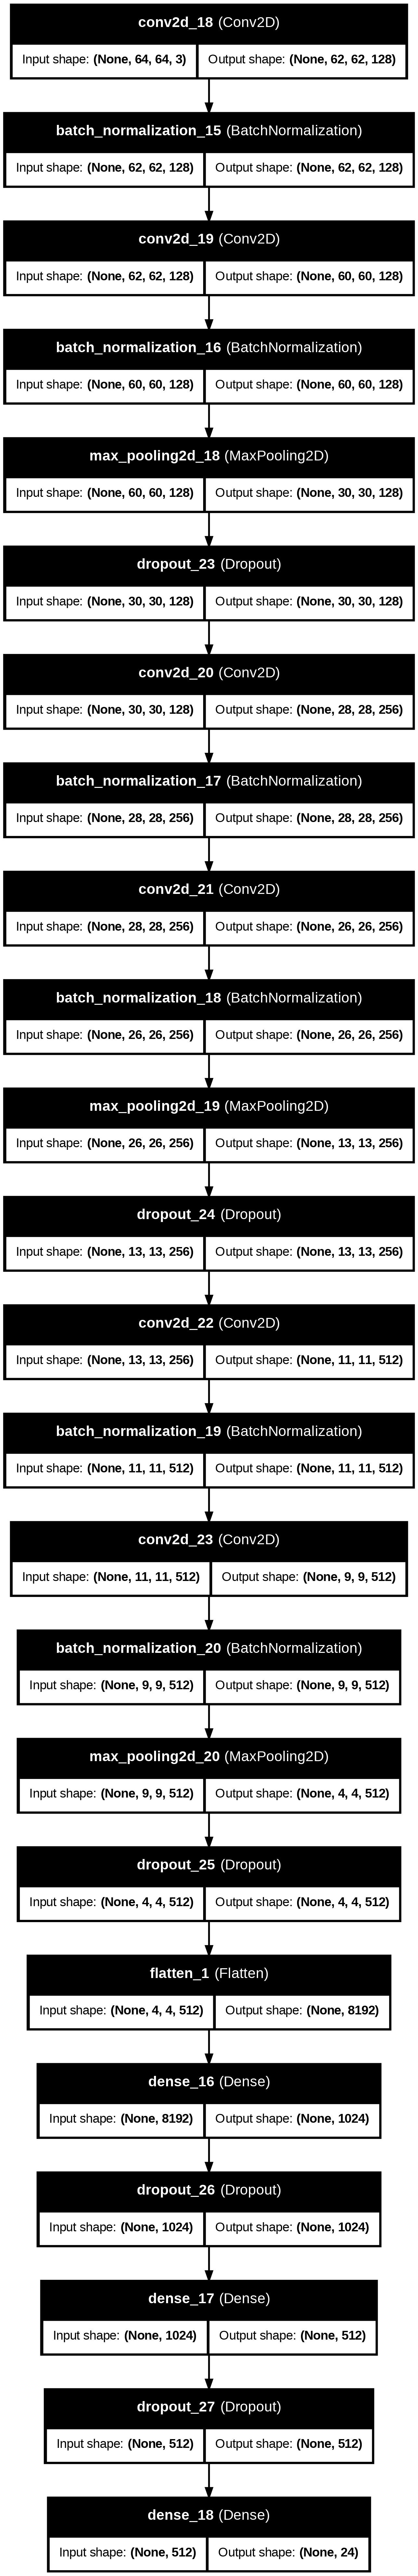

In [64]:
from tensorflow.keras.utils import plot_model

# Save the architecture as an image
plot_model(model, to_file='CNN_architecture.png', show_shapes=True, show_layer_names=True)

# Display the architecture image
from IPython.display import Image
Image('CNN_architecture.png')


In [65]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, 
    batch_size=BATCH_SIZE,  
    verbose=1  
)

Epoch 1/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 181s 352ms/step - accuracy: 0.4530 - loss: 6.0872 - val_accuracy: 0.1099 - val_loss: 6.2689
Epoch 2/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 120s 292ms/step - accuracy: 0.8878 - loss: 2.6221 - val_accuracy: 0.9541 - val_loss: 1.7396
Epoch 3/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 120s 291ms/step - accuracy: 0.9345 - loss: 1.7277 - val_accuracy: 0.8353 - val_loss: 1.9594
Epoch 4/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 120s 291ms/step - accuracy: 0.9480 - loss: 1.5812 - val_accuracy: 0.8017 - val_loss: 2.2429
Epoch 5/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 118s 287ms/step - accuracy: 0.9564 - loss: 1.5924 - val_accuracy: 0.7853 - val_loss: 2.2039
Epoch 6/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 117s 285ms/step - accuracy: 0.9557 - loss: 1.6971 - val_accuracy: 0.7903 - val_loss: 2.2375
Epoch 7/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 119s 288ms/step - accuracy: 0.9546 - loss: 1.7562 - val_accuracy: 0.8487 - val_loss: 2.0536
Epoch 8/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 117s 285ms/step - accuracy: 0.9573 -

In [66]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9530 - loss: 1.1118
Test Accuracy: 95.12%


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           a       1.00      0.73      0.84       282
           b       1.00      1.00      1.00       266
           c       1.00      0.97      0.98       264
           d       0.90      0.96      0.93       249
           e       0.99      1.00      1.00       281
           f       0.99      0.98      0.99       271
           g       1.00      0.93      0.96       296
           h       1.00      0.98      0.99       274
           i       1.00      0.94      0.97       266
           k       0.96      0.95      0.95       321
           l       0.99      0.99      0.99       276
           m       1.00      0.86      0.93       273
           n       0.84      1.00      0.91       268
           o       0.87      0.97      0.92       267
           p       1.00      0.84      0.91       244
           q       0.96      0.95      0.96       244
           r    

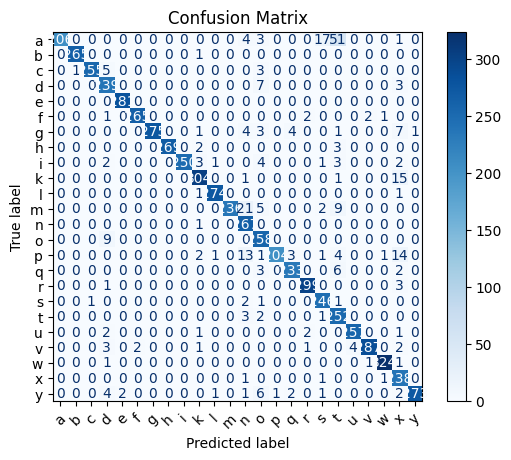

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


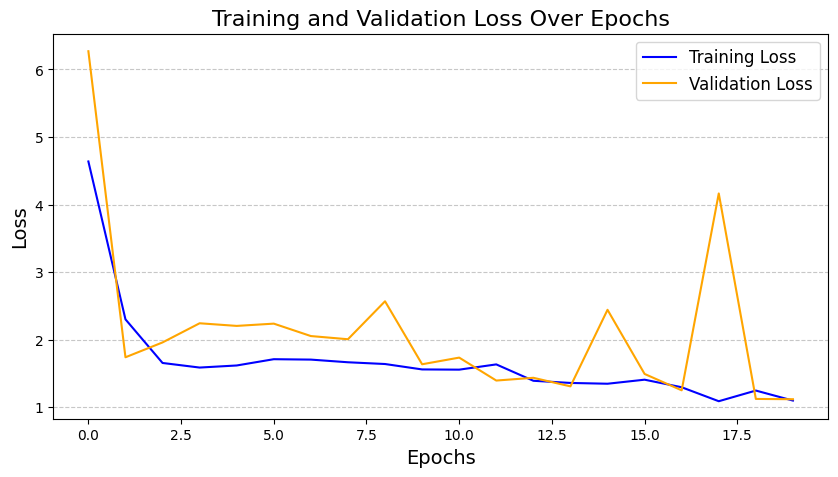

In [69]:
# Plot training and validation loss
def plot_loss(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_loss(history)


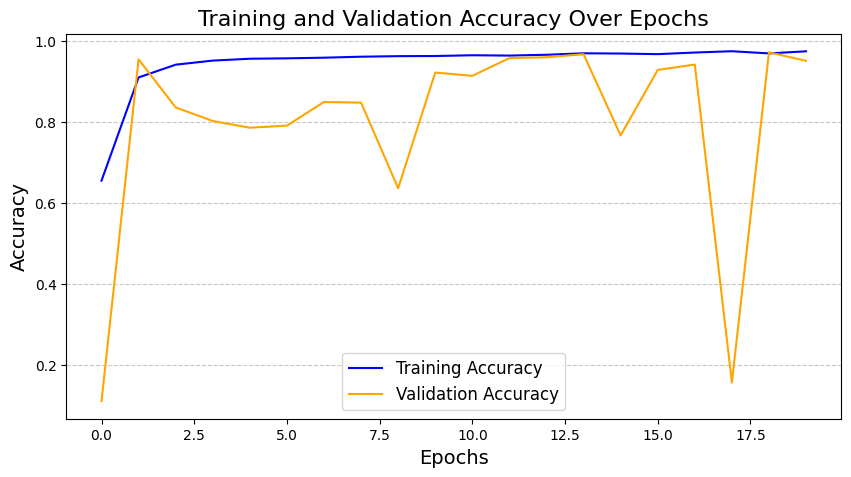

In [70]:
# Plot training and validation accuracy
def plot_accuracy(history):
    """
    Plots the training and validation accuracy over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_accuracy(history)


In [71]:
# Save the model in .h5 format
model.save('CNN.h5')
print("Model saved as CNN.h5")

Model saved as CNN.h5


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Weighted for multi-class
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print overall metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           a       1.00      0.73      0.84       282
           b       1.00      1.00      1.00       266
           c       1.00      0.97      0.98       264
           d       0.90      0.96      0.93       249
           e       0.99      1.00      1.00       281
           f       0.99      0.98      0.99       271
           g       1.00      0.93      0.96       296
           h       1.00      0.98      0.99       274
           i       1.00      0.94      0.97       266
           k       0.96      0.95      0.95       321
           l       0.99      0.99      0.99       276
           m       1.00      0.86      0.93       273
           n       0.84      1.00      0.91       268
           o       0.87      0.97      0.92       267
           p       1.00      0.84      0.91       244
          

# **ResNet-50**

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define the ResNet-50 model
def build_resnet50(input_shape, num_classes):
    # Load the ResNet-50 model without the top layers (pre-trained on ImageNet)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model's layers to prevent training them initially
    base_model.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = Dense(128, activation='relu')(x)  
    x = Dropout(0.5)(x)  
    output = Dense(num_classes, activation='softmax')(x)  
    
    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Model parameters
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)  
num_classes = len(label_encoder.classes_) 

# Build and compile the ResNet-50 model
model_Resnet = build_resnet50(input_shape, num_classes)
model_Resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_Resnet.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,853,080 (90.99 MB)

 Trainable params: 265,368 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    restore_best_weights=True  
)

In [31]:
history1 = model_Resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,           
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],  
    verbose=1
)

Epoch 1/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.0476 - loss: 3.2788 - val_accuracy: 0.1607 - val_loss: 3.1183
Epoch 2/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.1068 - loss: 3.1063 - val_accuracy: 0.1940 - val_loss: 3.0381
Epoch 3/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.1395 - loss: 3.0278 - val_accuracy: 0.2337 - val_loss: 2.9427
Epoch 4/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.1602 - loss: 2.9385 - val_accuracy: 0.2535 - val_loss: 2.8415
Epoch 5/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.1785 - loss: 2.8466 - val_accuracy: 0.2787 - val_loss: 2.7442
Epoch 6/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.1976 - loss: 2.7623 - val_accuracy: 0.2942 - val_loss: 2.6561
Epoch 7/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.2100 - loss: 2.6931 - val_accuracy: 0.3035 - val_loss: 2.5841
Epoch 8/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.2251 - loss: 2.6277 - 

In [32]:
test_loss, test_accuracy = model_Resnet.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5366 - loss: 1.6320
Test Accuracy: 53.44%


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           a       0.54      0.50      0.52       282
           b       0.57      0.70      0.63       266
           c       0.50      0.64      0.56       264
           d       0.51      0.43      0.46       249
           e       0.45      0.36      0.40       281
           f       0.69      0.71      0.70       271
           g       0.60      0.54      0.57       296
           h       0.61      0.71      0.66       274
           i       0.51      0.61      0.56       266
           k       0.53      0.57      0.55       321
           l       0.59      0.62      0.60       276
           m       0.42      0.58      0.49       273
           n       0.35      0.23      0.28       268
           o       0.52      0.48      0.50       267
           p       0.61      0.37      0.46       244
           q       0.52      0.52      0.52       244
           r    

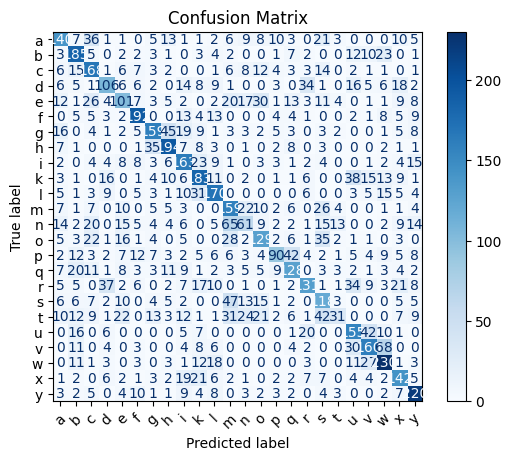

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
y_pred = model_Resnet.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

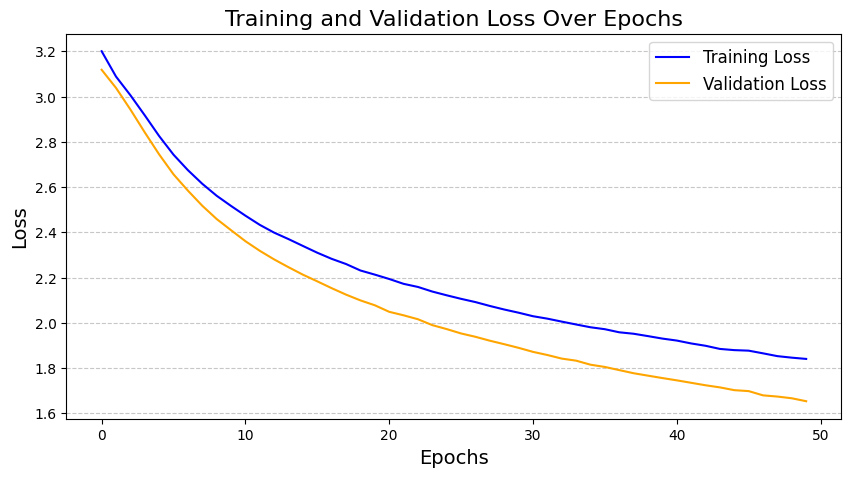

In [34]:
# Plot training and validation loss
def plot_loss(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_loss(history1)

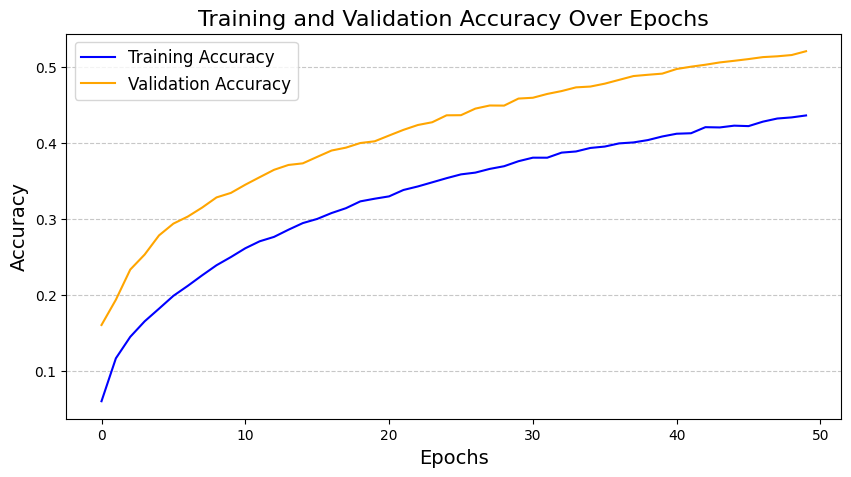

In [35]:
# Plot training and validation accuracy
def plot_accuracy(history):
    """
    Plots the training and validation accuracy over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_accuracy(history1)


## **FineTuning-ResNet50**

In [41]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True  
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_finetune = model_Resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],  
    verbose=1
)

Epoch 1/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.5137 - loss: 1.5784 - val_accuracy: 0.6019 - val_loss: 1.3475
Epoch 2/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.5162 - loss: 1.5768 - val_accuracy: 0.5992 - val_loss: 1.3482
Epoch 3/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5141 - loss: 1.5656 - val_accuracy: 0.6056 - val_loss: 1.3464
Epoch 4/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5202 - loss: 1.5585 - val_accuracy: 0.6065 - val_loss: 1.3393
Epoch 5/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5185 - loss: 1.5524 - val_accuracy: 0.6077 - val_loss: 1.3446
Epoch 6/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5193 - loss: 1.5594 - val_accuracy: 0.6095 - val_loss: 1.3361
Epoch 7/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5140 - loss: 1.5609 - val_accuracy: 0.6080 - val_loss: 1.3322
Epoch 8/100
412/412 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5194 - loss: 1

In [42]:
test_loss, test_accuracy = model_Resnet.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6724 - loss: 1.1316
Test Accuracy: 66.94%


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           a       0.68      0.74      0.71       282
           b       0.73      0.80      0.76       266
           c       0.65      0.76      0.70       264
           d       0.64      0.63      0.64       249
           e       0.57      0.53      0.55       281
           f       0.82      0.86      0.84       271
           g       0.75      0.68      0.72       296
           h       0.71      0.79      0.74       274
           i       0.68      0.73      0.70       266
           k       0.73      0.66      0.69       321
           l       0.72      0.75      0.73       276
           m       0.56      0.65      0.60       273
           n       0.50      0.43      0.46       268
           o       0.60      0.55      0.58       267
           p       0.63      0.52      0.57       244
           q       0.66      0.67      0.67       244
           r    

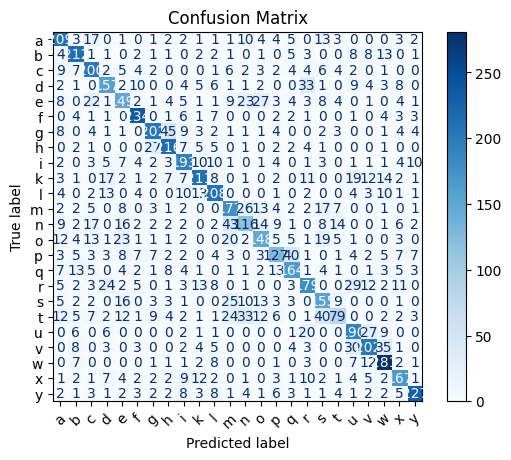

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
y_pred = model_Resnet.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

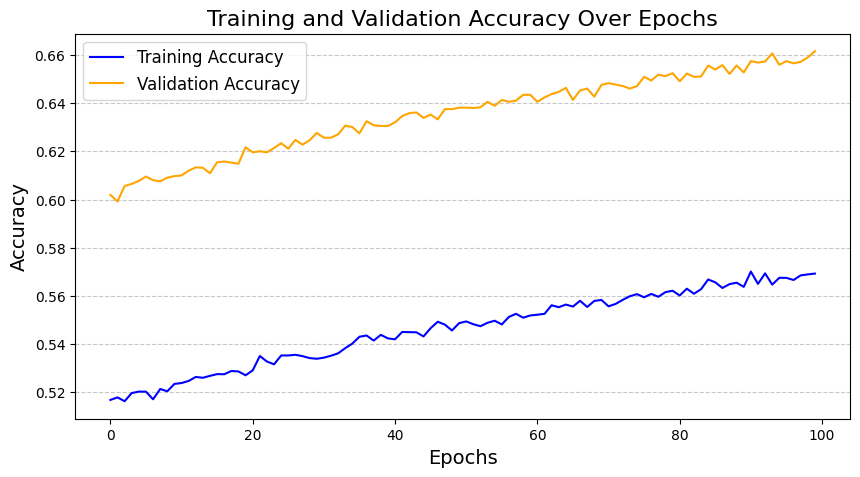

In [44]:
# Plot training and validation accuracy
def plot_accuracy(history):
    """
    Plots the training and validation accuracy over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_accuracy(history_finetune)


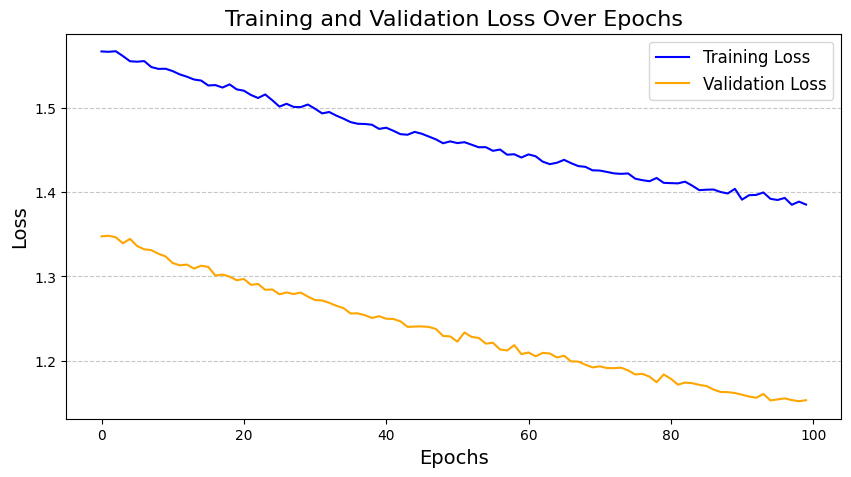

In [45]:
# Plot training and validation loss
def plot_loss(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
    - history: The History object returned by model.fit().
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Call the function after training
plot_loss(history_finetune)

In [75]:
# Save the model in .h5 format
model.save('Resnet.h5')
print("Model saved as Resnet.h5")

Model saved as Resnet.h5


In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Predict on the test set
y_pred = model_Resnet.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Weighted for multi-class
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print overall metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.67

Classification Report:
              precision    recall  f1-score   support

           a       0.68      0.74      0.71       282
           b       0.73      0.80      0.76       266
           c       0.65      0.76      0.70       264
           d       0.64      0.63      0.64       249
           e       0.57      0.53      0.55       281
           f       0.82      0.86      0.84       271
           g       0.75      0.68      0.72       296
           h       0.71      0.79      0.74       274
           i       0.68      0.73      0.70       266
           k       0.73      0.66      0.69       321
           l       0.72      0.75      0.73       276
           m       0.56      0.65      0.60       273
           n       0.50      0.43      0.46       268
           o       0.60      0.55      0.58       267
           p       0.63      0.52      0.57       244
          